Imports

In [ ]:
'''
Imports
'''
!pip install uniseg

import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import unicodedata
import re
import numpy as np
import os
import io
import time
import random
import shutil
from matplotlib.font_manager import FontProperties
import shutil
#HTMl library to generate the connectivity html file
from IPython.display import HTML as html_print
from IPython.display import display


In [ ]:
'''
Downloading the dataset
'''
# Download the dataset
!curl https://storage.googleapis.com/gresearch/dakshina/dakshina_dataset_v1.0.tar --output daksh.tar
# Extract the downloaded tar file
!tar -xvf  'daksh.tar'
# Set the file paths to train, validation and test dataset
#train_path
train_file_path=os.path.join(os.getcwd(),"dakshina_dataset_v1.0","hi","lexicons","hi.translit.sampled.train.tsv")
#validation_path
vaildation_file_path = os.path.join(os.getcwd(),"dakshina_dataset_v1.0","hi","lexicons","hi.translit.sampled.dev.tsv")
#test_path
test_file_path = os.path.join(os.getcwd(),"dakshina_dataset_v1.0","hi","lexicons","hi.translit.sampled.test.tsv")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1915M  100 1915M    0     0   228M      0  0:00:08  0:00:08 --:--:--  236M
dakshina_dataset_v1.0/bn/
dakshina_dataset_v1.0/bn/lexicons/
dakshina_dataset_v1.0/bn/lexicons/bn.translit.sampled.test.tsv
dakshina_dataset_v1.0/bn/lexicons/bn.translit.sampled.train.tsv
dakshina_dataset_v1.0/bn/lexicons/bn.translit.sampled.dev.tsv
dakshina_dataset_v1.0/bn/native_script_wikipedia/
dakshina_dataset_v1.0/bn/native_script_wikipedia/bn.wiki-filt.valid.text.shuf.txt.gz
dakshina_dataset_v1.0/bn/native_script_wikipedia/bn.wiki-full.info.sorted.tsv.gz
dakshina_dataset_v1.0/bn/native_script_wikipedia/bn.wiki-filt.train.info.sorted.tsv.gz
dakshina_dataset_v1.0/bn/native_script_wikipedia/bn.wiki-filt.train.text.sorted.tsv.gz
dakshina_dataset_v1.0/bn/native_script_wikipedia/bn.wiki-filt.train.text.shuf.txt.gz
dakshina_dataset_v1.0/bn/native_script

In [ ]:
'''
Preprocessing the words
'''
def word_process(w):
  #adding the tab and next line characters in the words
  w = '\t' + w + '\n'
  return w

'''
Function - Returns pairs of target word,input word.
'''
def create_dataset(path):
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
  #creating the word pairs
  word_pairs = [[word_process(w)  for w in line.split('\t')[:-1]]
                for line in lines[:-1]]
  return zip(*word_pairs)

'''
Function - tokenize the language
'''
def tokenize(lang):
  #using keras text tokenizer
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', char_level=True)
  lang_tokenizer.fit_on_texts(lang)
  #generating the sequence
  tensor = lang_tokenizer.texts_to_sequences(lang)
  #tensor used for pading the sequences
  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
  #retun the tensor and the language tokenizer
  return tensor, lang_tokenizer

'''
Function - load_dataset 
'''
def load_dataset(path):
  #creating the target word and input word pairs
  output_lang, inp_lang = create_dataset(path)

  #generating the tokenized tensor for the input words
  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  #generating the tokenized tensor for the target words
  output_tensor, output_lang_tokenizer = tokenize(output_lang)

  return input_tensor, output_tensor, inp_lang_tokenizer, output_lang_tokenizer

In [ ]:
'''
Reading the training dataset entirely
'''
# Use the entire training dataset file
input_tensor_train, target_tensor_train, inp_lang, targ_lang = load_dataset(train_file_path)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = target_tensor_train.shape[1], input_tensor_train.shape[1]

In [ ]:
'''
Class - GRU Encoder
'''
class GRU_Encoder(tf.keras.Model):
  #Initialization
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz, dropout=0):
    super(GRU_Encoder, self).__init__()
    self.batch_sz = batch_sz    #batch_size
    self.enc_units = enc_units  #encoder_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim) #embeding dimensions and layer initialization
    #keras GRU layer
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform',
                                   dropout = dropout)
  #calling the GRU encoder
  def call(self, x, hidden):
    #calling the embeding initializations
    x = self.embedding(x)
    #return the encoder output and the state
    output, state = self.gru(x, initial_state=hidden)
    return output, state

  #initialiaztion of the hidden states
  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

'''
class - LSTM encoder
'''
class LSTM_Encoder(tf.keras.Model):
  #initialization function
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz,dropout=0):
    super(LSTM_Encoder, self).__init__()
    self.batch_sz = batch_sz    #batch_size
    self.enc_units = enc_units  #encoder_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim) #embedding_dimensions
    #keras LSTM layer
    self.lstm = tf.keras.layers.LSTM(self.enc_units, 
                         return_sequences=True, 
                         return_state=True,
                         recurrent_initializer='glorot_uniform',
                         dropout = dropout)

  #call function
  def call(self, x, hidden,cell_state):
    #embedding layer calling
    x = self.embedding(x)
    #output and the last cell calling
    output, last_hidden,last_cell_state = self.lstm(x, initial_state=[hidden,cell_state])
    #return the output, last hidden and the last cell state
    return output, last_hidden,last_cell_state
    
  #initialization of the hidden state
  def initialize_hidden_state(self):
      return tf.zeros((self.batch_sz, self.enc_units)), tf.zeros((self.batch_sz, self.enc_units))

'''
class - RNN encoder
'''
class RNN_Encoder(tf.keras.Model):
  #intialization function
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz,dropout=0):
    super(RNN_Encoder, self).__init__()
    self.batch_sz = batch_sz    #batch size
    self.enc_units = enc_units  #encoder units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)   #embedding dimensions
    #keras RNN layer
    self.rnn = tf.keras.layers.SimpleRNN(self.enc_units, 
                         return_sequences=True, 
                         return_state=True,
                         recurrent_initializer='glorot_uniform',
                         dropout = dropout)

  #call function
  def call(self, x, hidden):
    #embedding layer calling
    x = self.embedding(x)
    #returning the output and the final state
    output, final_state = self.rnn(x,initial_state=hidden)
    return output, final_state
    
  #initialization of the hidden states
  def initialize_hidden_state(self):
      return tf.zeros((self.batch_sz, self.enc_units))

In [ ]:
'''
Attention class (Bhadanau Attention) refernce for the attention  - https://arxiv.org/abs/1409.0473
'''
class BahdanauAttention(tf.keras.layers.Layer):
  #initialization
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)  #W_1
    self.W2 = tf.keras.layers.Dense(units)  #W_2
    self.V = tf.keras.layers.Dense(1)       #V

  '''
  call function genrating the context vector and the attention weights
  '''
  def call(self, query, values):
    '''
    shape of query hidden state == (batch_size, hidden size)
    shape of query_with_time_axis == (batch_size, 1, hidden size)
    shape of values  == (batch_size, max_len, hidden size)
    '''
    #To broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # shape of score == (batch_size, max_length, 1)
    # shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    # shape of attention_weights == (batch_size, max_length, 1)
    #generating the attention weights
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    #generating the context vector
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    #returning the context vector and the attention weights
    return context_vector, attention_weights

In [ ]:
'''
class GRU Decoder 
'''
class GRU_Decoder(tf.keras.Model):
  #initialization
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz,dropout=0):
    super(GRU_Decoder, self).__init__()
    self.batch_sz = batch_sz    #batch size
    self.dec_units = dec_units  #decoder units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim) #embeding layer initialization
    #keras GRU layer
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform',dropout=dropout)
    #dense or fully connected layer
    self.fc = tf.keras.layers.Dense(vocab_size)

    #using the attention
    self.attention = BahdanauAttention(self.dec_units)

  #call function to generate the output, state and the attention weights
  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)
    # output shape after passing through embedding == (batch_size, 1, embedding_dim)
    output = self.embedding(x)
    # output shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    output = tf.concat([tf.expand_dims(context_vector, 1), output], axis=-1)
    # passing the concatenated vector to the GRU
    output, state = self.gru(output)
    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))
    # output shape == (batch_size, vocab)
    output = self.fc(output)
    #return the output, state and the attention weights.
    return output, state, attention_weights

'''
class LSTM decoder
'''
class LSTM_Decoder(tf.keras.Model):
  #initialization
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz,dropout=0):
    super(LSTM_Decoder, self).__init__()
    self.batch_sz = batch_sz    #batch size
    self.dec_units = dec_units  #decoder units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim) #embedding
    #keras LSTM layer
    self.lstm = tf.keras.layers.LSTM(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform',dropout=dropout)
    #dense/ Fully connected layer
    self.fc = tf.keras.layers.Dense(vocab_size)

    #applying the attention layer
    self.attention = BahdanauAttention(self.dec_units)

  #call function generating output, hiddden and cell state and the attention weights
  def call(self, x, hidden, enc_output,cell_state):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)
    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    output = self.embedding(x)
    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    output = tf.concat([tf.expand_dims(context_vector, 1), output], axis=-1)
    # passing the concatenated vector to the GRU
    output, last_hidden_state,last_cell_state = self.lstm(output,initial_state=[hidden,cell_state])
    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))
    # output shape == (batch_size, vocab)
    output = self.fc(output)
    #returning output, hiddden and cell state and the attention weights
    return output, [last_hidden_state,last_cell_state], attention_weights

'''
Class RNN decoder
'''
class RNN_Decoder(tf.keras.Model):
  #initialization
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz,dropout=0):
    super(RNN_Decoder, self).__init__()
    self.batch_sz = batch_sz    #batch size
    self.dec_units = dec_units  #decoder unnits
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim) #embedding layer
    #keras RNN layer
    self.rnn = tf.keras.layers.SimpleRNN(self.dec_units, 
                         return_sequences=True, 
                         return_state=True,
                         recurrent_initializer='glorot_uniform',
                         dropout = dropout)
    #dense/ fully connected layer
    self.fc = tf.keras.layers.Dense(vocab_size)
    #applying attention layer
    self.attention = BahdanauAttention(self.dec_units)


  #call function generating the output state and the attention weights
  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)
    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    output = self.embedding(x)
    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    output = tf.concat([tf.expand_dims(context_vector, 1), output], axis=-1)
    # passing the concatenated vector to the GRU
    output, final_state = self.rnn(output)
    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))
    # output shape == (batch_size, vocab)
    output = self.fc(output)
    #return the output state and the attention weights
    return output, final_state, attention_weights

In [ ]:
'''
Fucntion - Calculating the loss function
Reference: https://stackoverflow.com/questions/62916592/loss-function-for-sequences-in-tensorflow-2-0
'''
def calculate_loss(real, pred):
  mask_position = tf.math.logical_not(tf.math.equal(real, 0))
  loss_value = loss_object(real, pred)

  mask_position = tf.cast(mask_position, dtype=loss_value.dtype)
  loss_value *= mask_position

  #returns the mean of the loss value
  return tf.reduce_mean(loss_value)

In [ ]:
def build_model(vocab_inp_size, vocab_tar_size, embedding_dim, units, BATCH_SIZE, dropout,train_input_batch):
    #Encoder
    if rnn_type=='GRU': #GRU
       encoder = GRU_Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE, dropout)
       sample_hidden = encoder.initialize_hidden_state()
       sample_output, sample_hidden = encoder(train_input_batch, sample_hidden)
    elif rnn_type=='LSTM': #LSTM
      encoder = LSTM_Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE, dropout)
      sample_hidden,sample_cell_state = encoder.initialize_hidden_state()
      sample_output, sample_hidden,sample_cell_state = encoder(train_input_batch, sample_hidden,sample_cell_state)
    elif rnn_type=='RNN': #RNN
      encoder = RNN_Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE, dropout)
      sample_hidden = encoder.initialize_hidden_state()
      sample_output, sample_hidden = encoder(train_input_batch, sample_hidden)
    #printing the shapes
    print('Encoder output shape: (batch size, sequence length, units)', sample_output.shape)
    print('Encoder Hidden state shape: (batch size, units)', sample_hidden.shape)
    
    #Decoder
    if rnn_type=='GRU': #GRU
      decoder = GRU_Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE, dropout)
      sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)), sample_hidden, sample_output)
    
    elif rnn_type=='LSTM': #LSTM
      decoder = LSTM_Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE, dropout)
      sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)), sample_hidden, sample_output, sample_cell_state)
    
    elif rnn_type=='RNN': #RNN
      decoder = RNN_Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE, dropout)
      sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)), sample_hidden, sample_output)
      
    #print the decoder shape
    print('Decoder output shape: (batch_size, vocab size)', sample_decoder_output.shape)

    return encoder,decoder

In [ ]:
def train_epochs(EPOCHS,encoder,decoder,dataset,steps_per_epoch):
    train_loss=[0]*EPOCHS
    for epoch in range(EPOCHS):
      start = time.time()
      if rnn_type!='LSTM': #GRU or RNN
        enc_hidden = encoder.initialize_hidden_state()
      elif rnn_type=='LSTM': #LSTM
        enc_hidden,enc_cell_state = encoder.initialize_hidden_state()
      total_loss = 0
      for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        #Training for every batch
        if rnn_type!='LSTM':
          batch_loss = train_batch(inp, targ, enc_hidden, encoder,decoder,rnn_type)
        elif rnn_type=='LSTM':
          batch_loss = train_batch(inp, targ, [enc_hidden,enc_cell_state], encoder,decoder,rnn_type)
        total_loss += batch_loss
      if batch % 100 == 0:
        #printing the batch loss
        print(f'Epoch {epoch+1} Batch {batch} Loss {batch_loss.numpy():.4f}')
        
      # saving (checkpoint) the model every 2 epochs
      if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix=checkpoint_prefix)
      #print the trtaining loss for the epoch
      print(f'Epoch {epoch+1} Loss {total_loss/steps_per_epoch:.4f}')
      print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')
      # Storing the average loss per epoch
      train_loss[epoch] = total_loss.numpy()/steps_per_epoch

    return train_loss

In [ ]:
def train(use_wandb=True):
    global BATCH_SIZE 
    global units 
    global vocab_inp_size
    global vocab_tar_size
    global embedding_dim
    global encoder
    global decoder
    global optimizer
    global loss_object
    global checkpoint_dir
    global checkpoint_prefix 
    global checkpoint
    global run_name
    global rnn_type


    '''
    Wandb configuration
    '''
    # initialising the wandb run
    run = wandb.init()
    # Tpye of RNN to choose. Acceptable Values are 'RNN'. 'LSTM' and 'GRU'
    rnn_type = run.config.rnn_type
    # Batch size for training.
    BATCH_SIZE = run.config.bs
    # Dimensions of the abstract representation of the input word and target word.
    embedding_dim = run.config.embed
    # Latent dimensions of the encoder and decoder.
    units = run.config.latent
    # Number of epochs to train for.
    EPOCHS = run.config.epochs
    #	Float between 0 and 1. Denotes the fraction of the units to drop.
    dropout = run.config.dropout


    print("rnn_Type: ",rnn_type)
    #buffer size
    BUFFER_SIZE = len(input_tensor_train)
    #steps per epoch
    steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
    #vocab input size
    vocab_inp_size = len(inp_lang.word_index)+1
    #vocab target size
    vocab_tar_size = len(targ_lang.word_index)+1
    
    #wandb run name
    run_name = '_epochs_'+str(EPOCHS)+'_rnn_type_'+str(rnn_type)+'_bs_'+str(BATCH_SIZE)+'_embed_'+str(embedding_dim)+'_latent_'+str(units)+'_dropout_'+str(dropout)
    if use_wandb==True:
      wandb.run.name = run_name

    dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
    # We create batches of size BATCH_SIZE and ignore the last batch because the last batch may not be equal to BATCH_SIZE
    #creating the batches
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    
    train_input_batch, train_target_batch = next(iter(dataset))
    
    encoder, decoder = build_model(vocab_inp_size, vocab_tar_size, embedding_dim, units, BATCH_SIZE, dropout,train_input_batch)
  
    #Apply the adam optimizer
    optimizer = tf.keras.optimizers.Adam()
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
    
    #saving the checkpoints
    checkpoint_dir = os.path.join(os.getcwd(),'training_checkpoints')
    checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
    checkpoint = tf.train.Checkpoint(optimizer=optimizer, encoder=encoder, decoder=decoder)
        
    ####################################################################### Hyper parameter Tuning (Training) ###############################################################
    
    train_loss=[0]*EPOCHS
    for epoch in range(EPOCHS):
      start = time.time()
      if rnn_type!='LSTM': #GRU or RNN
        enc_hidden = encoder.initialize_hidden_state()
      elif rnn_type=='LSTM': #LSTM
        enc_hidden,enc_cell_state = encoder.initialize_hidden_state()
      total_loss = 0
      for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        #Training for every batch
        if rnn_type!='LSTM':
          batch_loss = train_batch(inp, targ, enc_hidden, encoder,decoder,rnn_type)
        elif rnn_type=='LSTM':
          batch_loss = train_batch(inp, targ, [enc_hidden,enc_cell_state], encoder,decoder,rnn_type)
        total_loss += batch_loss
      if batch % 100 == 0:
        #printing the batch loss
        print(f'Epoch {epoch+1} Batch {batch} Loss {batch_loss.numpy():.4f}')
        
      # saving (checkpoint) the model every 2 epochs
      if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix=checkpoint_prefix)
      #print the trtaining loss for the epoch
      print(f'Epoch {epoch+1} Loss {total_loss/steps_per_epoch:.4f}')
      print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')
      # Storing the average loss per epoch
      train_loss[epoch] = total_loss.numpy()/steps_per_epoch
      #logging the training loss in wandb
      if use_wandb == True:
        wandb.log({"train_loss": total_loss.numpy()/steps_per_epoch})

        
    #test_accuracy = validate(test_file_path,run_name)
    val_acc=validate(vaildation_file_path,rnn_type)
    print("Train loss: ",train_loss)
    print("Validation Accuracy: ",val_acc)
    #print("Test Accuracy: ",test_accuracy)
    if use_wandb ==True:
      wandb.log({'val_accuracy': val_acc})
    
    checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
'''
Function for training manually the best configuration of the model
'''
def manual_train():
    global BATCH_SIZE 
    global units 
    global vocab_inp_size
    global vocab_tar_size
    global embedding_dim
    global encoder
    global decoder
    global optimizer
    global loss_object
    global checkpoint_dir
    global checkpoint_prefix 
    global checkpoint
    global run_name
    global rnn_type

    '''
    Best configuration of the model
    '''
    rnn_type = 'LSTM'
    BATCH_SIZE = 64
    embedding_dim = 512
    units = 1024
    EPOCHS = 20
    dropout = 0.2

    print("rnn_Type: ",rnn_type)
    #generating the buffer size
    BUFFER_SIZE = len(input_tensor_train)
    #calculating the number of steps per epoch
    steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
    #vocab input size
    vocab_inp_size = len(inp_lang.word_index)+1
    #vocab target size
    vocab_tar_size = len(targ_lang.word_index)+1

    run_name = '_epochs_'+str(EPOCHS)+'_rnn_type_'+str(rnn_type)+'_bs_'+str(BATCH_SIZE)+'_embed_'+str(embedding_dim)+'_latent_'+str(units)+'_dropout_'+str(dropout)
    
    dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
    #We are creating batches of size BATCH_SIZE and ignore the last batch because the last batch may not be equal to BATCH_SIZE
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    
    train_input_batch, train_target_batch = next(iter(dataset))
    
    encoder, decoder = build_model(vocab_inp_size, vocab_tar_size, embedding_dim, units, BATCH_SIZE, dropout,train_input_batch)

    #apply the adam optimizer
    optimizer = tf.keras.optimizers.Adam()
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
    
    #creating and saving the checkpoints
    checkpoint_dir = os.path.join(os.getcwd(),'training_checkpoints')
    checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
    checkpoint = tf.train.Checkpoint(optimizer=optimizer, encoder=encoder, decoder=decoder)
    
    train_loss=[0]*EPOCHS
    
    ############################################################################## Training ##########################################################################

    train_loss = train_epochs(EPOCHS,encoder,decoder,dataset,steps_per_epoch)

        
    #calculating the test accuracy using the validate function
    test_accuracy = validate(test_file_path,run_name)
    #calcualting the validation accuracy using validate function
    val_acc=validate(vaildation_file_path,rnn_type)
    print("Train loss: ",train_loss)
    print("Validation Accuracy: ",val_acc)
    print("Test Accuracy: ",test_accuracy)
    
 	  # restoring the latest checkpoint in checkpoint_dir and starting the test
  	# checkpoints are only useful when source code that will use the saved parameter values is available.
    checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
    generate_inputs(rnn_type,10)
    #generating the connectivity of the best model.
    connectivity(['maryaadaa','prayogshala','angarakshak'],rnn_type, os.path.join(os.getcwd(),"predictions_attention",str(run_name)))

In [ ]:
'''
Function - train_batch
calculates the loss of the batch and returns the batch loss after training every batch in each epoch
'''
@tf.function
def train_batch(inp, targ, enc_hidden, enocder, decoder,rnn_type):
  #Final loss value
  loss = 0
  with tf.GradientTape() as tape:
        #checking if it is GRU or RNN
        if rnn_type!='LSTM':
            enc_output, enc_hidden = encoder(inp, enc_hidden)
            dec_hidden = enc_hidden
        #checking if it is LSTM
        elif rnn_type=='LSTM':
            enc_output, enc_hidden,enc_cell_state = encoder(inp, enc_hidden[0],enc_hidden[1])
            dec_hidden = enc_hidden
            dec_cell_state=enc_cell_state
        
        #geting the decoder input
        dec_input = tf.expand_dims([targ_lang.word_index['\t']] * BATCH_SIZE, 1)
        
        #Teacher forcing
        for t in range(1, targ.shape[1]):
            if rnn_type!='LSTM':
                # passing enc_output to the decoder if it is RNN or GRU
                predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
            elif rnn_type=='LSTM':
                if t==1:
                  # passing enc_output to the decoder if it is a LSTM
                  predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output,dec_cell_state)
                elif t>1:
                  # passing enc_output to the decoder if it is a LSTM
                  predictions, dec_hidden, _ = decoder(dec_input, dec_hidden[0], enc_output,dec_cell_state)
            #calculating the loss using calculate loss function
            loss += calculate_loss(targ[:, t], predictions)
            #using teacher forcing
            dec_input = tf.expand_dims(targ[:, t], 1)
  #calculating the batch loss
  batch_loss = (loss / int(targ.shape[1]))
  #calculate the variables
  variables = encoder.trainable_variables + decoder.trainable_variables
  #calculate the gradients
  gradients = tape.gradient(loss, variables)
  #applying the gradients to the optimizer
  optimizer.apply_gradients(zip(gradients, variables))
  return batch_loss

In [ ]:
'''
Function - inference_model
generating the predicted word, input word, attention weights and the attention plot
'''
def inference_model(input_word,rnn_type):
  #creating an empty attention plot
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  #preprocessing the input word
  input_word = word_process(input_word)

  #converting the word to tensor after pading
  inputs = [inp_lang.word_index[i] for i in input_word]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen=max_length_inp, padding='post')
  inputs = tf.convert_to_tensor(inputs)

  #predicted word initialization
  predicted_word = ''
  
  #if cell type is GRU or RNN
  if rnn_type!='LSTM':
    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)
    dec_hidden = enc_hidden
  #if cell type is LSTM
  elif rnn_type=='LSTM':
    hidden=tf.zeros((1, units))
    cell_state= tf.zeros((1, units)) 
    enc_out, enc_hidden,enc_cell_state = encoder(inputs, hidden,cell_state)
    dec_hidden = enc_hidden

  #generating the decode inputs
  dec_input = tf.expand_dims([targ_lang.word_index['\t']], 0)

  #storing the attention weights
  att_w=[]

  #calculating the predictions
  for t in range(max_length_targ):
    #if cell is GRU or RNN
    if rnn_type!='LSTM':
      predictions, dec_hidden, attention_weights = decoder(dec_input,dec_hidden,enc_out)
    #if cell is LSTM
    elif rnn_type=='LSTM':
      predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out, enc_cell_state)
      dec_hidden=dec_hidden[0]

    # storing the attention weights for plotting latter
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()
    att_w.append(attention_weights.numpy()[0:len(input_word)])
    

    #predicted id
    predicted_id = tf.argmax(predictions[0]).numpy()
    #predicted word
    predicted_word += targ_lang.index_word[predicted_id] 

    #in case of last character
    if targ_lang.index_word[predicted_id] == '\n':
      return predicted_word, input_word, attention_plot,att_w

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)
  #finally return the predicted word, input word, attention plot and the attention weight
  return predicted_word, input_word, attention_plot,att_w

In [ ]:
'''
Function - Validate
returning the validation or the testing accuracy on the validation data
'''
def validate(path_to_file,folder_name):
  #while testing to generate the predictions files (output files)
  save = False
  if path_to_file.find("test")!=-1:
    if os.path.exists(os.path.join(os.getcwd(),"predictions_attention",str(folder_name))):
      shutil.rmtree(os.path.join(os.getcwd(),"predictions_attention",str(folder_name)))
      
    if not os.path.exists(os.path.join(os.getcwd(),"predictions_attention")):
        os.mkdir(os.path.join(os.getcwd(),"predictions_attention"))
    os.mkdir(os.path.join(os.getcwd(),"predictions_attention",str(folder_name)))
    success_file = open(os.path.join(os.getcwd(),"predictions_attention",str(folder_name),"success.txt"),"w",encoding='utf-8', errors='ignore')
    failure_file = open(os.path.join(os.getcwd(),"predictions_attention",str(folder_name),"failure.txt"),"w",encoding='utf-8', errors='ignore')
    save=True
    
  #the count of the correct predictions
  success_count=0
  # Get the target words and input words for the validation
  target_words, input_words = create_dataset(path_to_file)
  for i in range(len(input_words)):
    #generate the predicted words for the corresponding input words
    predicted_word, input_word, attention_plot,att_w = inference_model(input_words[i],rnn_type)
    record= input_word.strip()+' '+target_words[i].strip()+' '+predicted_word[:-1].strip()+"\n"
    # The last character of target_words[i] and predicted word is '\n', first character of target_words[i] is '\t'
    if target_words[i][1:]==predicted_word:
      #increasing the accuracy count
      success_count = success_count + 1
      if save == True:
        success_file.write(record)
    elif save==True:
      failure_file.write(record)

  #saving the files
  if save==True:
    success_file.close()
    failure_file.close()
    
  #return the acuracy
  return success_count/len(input_words)

In [ ]:
'''
Function  - plot - attention
Function ploting the attention plots.
'''
def plot_attention(attention, input_word, predicted_word, file_name):
  #loading the hindi font for displaying
  hindi_font = FontProperties(fname = os.path.join(os.getcwd(),"Nirmala.ttf"))
  
  #figure matplotlib
  fig = plt.figure(figsize=(3, 3))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')
  
  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + list(input_word), fontdict=fontdict, rotation=0)
  ax.set_yticklabels([''] + list(predicted_word), fontdict=fontdict,fontproperties=hindi_font)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  #save the plot figure.
  plt.savefig(file_name)
  plt.show()

In [ ]:
'''
Geting the connectivity html file.
'''
# get html element
def cstr(s, color='black'):
	if s == ' ':
		return "<text style=color:#000;padding-left:10px;background-color:{}> </text>".format(color, s)
	else:
		return "<text style=color:#000;background-color:{}>{} </text>".format(color, s)
	
# print html
def print_color(t):
	display(html_print(''.join([cstr(ti, color=ci) for ti,ci in t])))

# get appropriate color for value
# Darker shades of green denotes higher importance.
def get_clr(value):
	colors = ['#85c2e1', '#89c4e2', '#95cae5', '#99cce6', '#a1d0e8',
		'#b2d9ec', '#baddee', '#c2e1f0', '#eff7fb', '#f9e8e8',
		'#f9e8e8', '#f9d4d4', '#f9bdbd', '#f8a8a8', '#f68f8f',
		'#f47676', '#f45f5f', '#f34343', '#f33b3b', '#f42e2e']
	value = int((value * 100) / 5)
	return colors[value]


'''
Function - Visualize the connectivity plots in the HTMl file
'''
def visualize(input_word, output_word, att_w):
  for i in range(len(output_word)):
    print("\nOutput character:", output_word[i], "\n")
    text_colours = []
    for j in range(len(att_w[i])):
      text = (input_word[j], get_clr(att_w[i][j]))
      text_colours.append(text)
    print_color(text_colours)

In [ ]:
'''
Code for connectivity visualisation.
'''
# get appropriate color for value
# Darker shades of green denotes higher importance.
def get_shade_color(value):
	colors = ['#00fa00', '#00f500',  '#00eb00', '#00e000',  '#00db00',  
           '#00d100',  '#00c700',  '#00c200', '#00b800',  '#00ad00',  
           '#00a800',  '#009e00',  '#009400', '#008f00',  '#008500',
           '#007500',  '#007000',  '#006600', '#006100',  '#005c00',  
           '#005200',  '#004d00',  '#004700', '#003d00',  '#003800',  
           '#003300',  '#002900',  '#002400',  '#001f00',  '#001400']
	value = int((value * 100) / 5)
	return colors[value]

#creating the HTMl file
def create_file(text_colors,input_word,output_word,file_path=os.getcwd()):
  text = '''
  <!DOCTYPE html>
  <html>
  <head>
    <meta charset="UTF-8"> 
    <script src="https://ajax.googleapis.com/ajax/libs/jquery/3.5.1/jquery.min.js"></script>
    <script>
            $(document).ready(function(){
            var col =['''
  for k in range(3):
      for i in range(len(output_word)):
              text=text+'''['''
              for j in range(len(text_colors[k][i])-1):
                text=text+'''\"'''+text_colors[k][i][j]+'''\"'''+''','''
              text=text+'''\"'''+text_colors[k][i][len(text_colors[k][i])-1]+'''\"'''+'''],'''
  text=text[0:-1]
  text=text+'''];\n'''
  
  for k in range(3):
      for i in range(len(output_word[k])):
            text=text+'''$(\".h'''+str(k)+str(i)+'''\").mouseover(function(){\n'''
            for j in range(len(input_word[k])):
                       text=text+'''$(\".t'''+str(k)+str(j)+'''\").css(\"background-color\", col['''+str(i)+''']'''+'''['''+str(j)+''']);\n'''
            text=text+'''});\n'''
            text=text+'''$(\".h'''+str(k)+str(i)+'''\").mouseout(function(){\n'''
            for l in range(3):
              for j in range(len(input_word[l])):
                text=text+'''$(\".t'''+str(l)+str(j)+'''\").css(\"background-color\", \"#ffff99\");\n'''
            text=text+'''});\n'''
  text=text+'''});\n
</script>
  </head>
      <body>
          <h1>Connectivity:</h1>
          <p> The connection strength between the target for the selected character and the input characters is highlighted in green (reset). Hover over the text to change the selected character.</p>
          <div style="background-color:#ffff99;color:black;padding:2%; margin:4%;">
          <p>
          <div> Output: </div>
          <div style='display:flex; border: 2px solid #d0cccc; padding: 8px; margin: 8px;'>
          '''
  for k in range(3):
      for i in range(len(output_word[k])):
            text=text+'''\n'''+'''\t'''+'''<div class="h'''+str(k)+str(i)+'''\">'''+output_word[k][i]+'''</div>'''
      text=text+'''</div>'''+'\n'+'\t'+'''<div>  </p>'''+'\n'+'\t'+'''<p>
      <div> Input: </div>
      <div style='display:flex; border: 2px solid #d0cccc; padding: 8px; margin: 8px;'>'''    
      for j in range(len(input_word[k])):
        text=text+'''\n'''+'''\t'''+'''<div class="t'''+str(k)+str(j)+'''\">'''+input_word[k][j]+'''</div>'''
      if k<2:
          text = text+'''</div></p></div><p></p></div>
          <div style="background-color:#ffff99;color:black;padding:2%; margin:4%;">
          <div> Output: </div>
          <div style='display:flex; border: 2px solid #d0cccc; padding: 8px; margin: 8px;'>'''
  text=text+'''
        </div>
        </p>
        </div>
        </body>
  </html>
  '''
  fname = os.path.join(file_path,"connectivity.html")
  file = open(fname,"w")
  file.write(text)
  file.close()

#main file to generate the connectivity of HTML file
def connectivity(input_words,rnn_type,file_path):
  #color list
  color_list=[]
  #input word list
  input_word_list=[]
  #output word list
  output_word_list=[]

  for k in range(3):
    #do inferencing in the model
    output_word, input_word, _ ,att_w = inference_model(input_words[k],rnn_type)
    text_colours=[]
    for i in range(len(output_word)):
      colour=[]
      for j in range(len(att_w[i])):
        value=get_shade_color(att_w[i][j])
        colour.append(value)
      text_colours.append(colour)
    #creating the color list
    color_list.append(text_colours)
    #input word list
    input_word_list.append(input_word)
    #output word list
    output_word_list.append(output_word)
  #create file for generating the HTML file
  create_file(color_list,input_word_list,output_word_list,file_path)

In [ ]:
'''
Function - Transliteration
generating the attention heatmap
'''
def transliterate(input_word,rnn_type,file_name=os.path.join(os.getcwd(),"attention_heatmap.png"),visual_flag=True):
  #do inferencing ot get the predicted word and other attention plots, weights and input word
  predicted_word, input_word, attention_plot,att_w = inference_model(input_word,rnn_type)

  #geting the predicted transliterations
  print("\n",'Input:', input_word)
  print('Predicted transliteration:', predicted_word)

  attention_plot = attention_plot[:len(predicted_word),
                                  :len(input_word)]
  plot_attention(attention_plot, input_word, predicted_word, file_name)

  if visual_flag == True:
    #visualize the attention plots
    visualize(input_word, predicted_word, att_w)

In [ ]:
'''
Fucntion - generate_inputs
generate the predictions for the attention based model
'''
def generate_inputs(rnn_type,n_test_samples=10):
  target_words, input_words = create_dataset(test_file_path)
  
  for i in range (n_test_samples):
    index = random.randint(0,len(input_words))
    input_word=input_words[index]
    file_name=os.path.join(os.getcwd(),"predictions_attention",str(run_name),input_word+".png")
    
    if i == 0:
      transliterate(input_word[1:-1],rnn_type, file_name,True)
    elif i > 0:
      transliterate(input_word[1:-1],rnn_type, file_name,False)

In [ ]:
'''
Sweep configuration for hyper parameter tuning
'''
!pip install wandb --upgrade
import wandb
!wandb login
sweep_config = {
    "name": "Bayesian Sweep without attention",
    "method": "bayes",
    "metric": {"name": "val_accuracy", "goal": "maximize"},
    "parameters": {
        
        "rnn_type": {"values": ["RNN","GRU","LSTM"]},
        
        "embed": {"values": [256,512]},
        
        "latent": {"values": [512,1024]},
        
        "dropout": {"values": [0.1, 0.2, 0.3]},

        "epochs": {"values": [20]},
        
        "bs": {"values": [64]},


    },
  }

sweep_id = wandb.sweep(sweep_config, project="CS6910_Assignment3_attention", entity="cs21m007_cs21m013")

wandb.agent(sweep_id, train, count = 30)

rnn_Type:  LSTM
Encoder output shape: (batch size, sequence length, units) (64, 22, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)
Decoder output shape: (batch_size, vocab size) (64, 65)
Epoch 1 Loss 0.3846
Time taken for 1 epoch 149.47 sec

Epoch 2 Loss 0.1350
Time taken for 1 epoch 114.57 sec

Epoch 3 Loss 0.1000
Time taken for 1 epoch 116.41 sec

Epoch 4 Loss 0.0779
Time taken for 1 epoch 117.66 sec

Epoch 5 Loss 0.0604
Time taken for 1 epoch 116.97 sec

Epoch 6 Loss 0.0492
Time taken for 1 epoch 117.78 sec

Epoch 7 Loss 0.0375
Time taken for 1 epoch 116.92 sec

Epoch 8 Loss 0.0334
Time taken for 1 epoch 117.67 sec

Epoch 9 Loss 0.0298
Time taken for 1 epoch 117.01 sec

Epoch 10 Loss 0.0275
Time taken for 1 epoch 117.36 sec

Epoch 11 Loss 0.0255
Time taken for 1 epoch 117.16 sec

Epoch 12 Loss 0.0258
Time taken for 1 epoch 117.30 sec

Epoch 13 Loss 0.0258
Time taken for 1 epoch 117.11 sec

Epoch 14 Loss 0.0225
Time taken for 1 epoch 117.44 sec

Epoch 15 Loss 0.0219

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


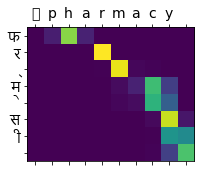


Output character: फ 




Output character: र 




Output character: ् 




Output character: म 




Output character: े 




Output character: स 




Output character: ी 




Output character: 
 




 Input: 	agr

Predicted transliteration: अग्र



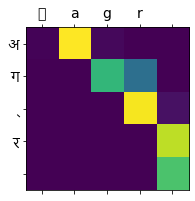


 Input: 	mahanatam

Predicted transliteration: महानतम



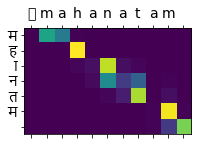


 Input: 	joddta

Predicted transliteration: जोडता



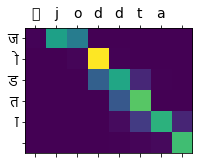


 Input: 	katthaii

Predicted transliteration: कट्ठाई



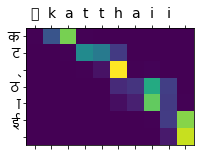


 Input: 	vishahin

Predicted transliteration: विषाहिन



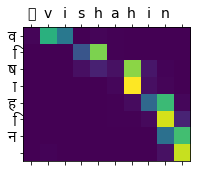


 Input: 	bolane

Predicted transliteration: बोलने



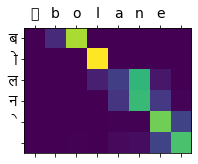


 Input: 	nikalegi

Predicted transliteration: निकालेगी



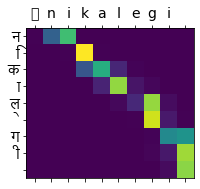


 Input: 	mamuli

Predicted transliteration: मामुली



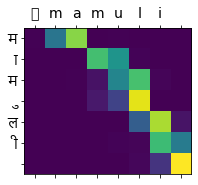


 Input: 	bhagane

Predicted transliteration: भागने



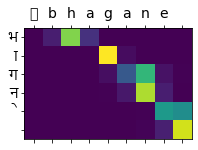

In [ ]:
'''
manual training for the best parameter model
'''
manual_train()

In [ ]:
#Download a copy of the predictions_attention and training_checkpoints folder.
!zip -r /content/predictions_attention.zip /content/predictions_attention
!zip -r /content/training_checkpoints.zip /content/training_checkpoints
from google.colab import files
files.download("/content/predictions_attention.zip")
files.download("/content/training_checkpoints.zip")

  adding: content/predictions_attention/ (stored 0%)
  adding: content/predictions_attention/_epochs_20_rnn_type_LSTM_bs_64_embed_512_latent_1024_dropout_0.2/ (stored 0%)
  adding: content/predictions_attention/_epochs_20_rnn_type_LSTM_bs_64_embed_512_latent_1024_dropout_0.2/^Ibolane^J.png (deflated 11%)
  adding: content/predictions_attention/_epochs_20_rnn_type_LSTM_bs_64_embed_512_latent_1024_dropout_0.2/^Ipharmacy^J.png (deflated 8%)
  adding: content/predictions_attention/_epochs_20_rnn_type_LSTM_bs_64_embed_512_latent_1024_dropout_0.2/connectivity.html (deflated 96%)
  adding: content/predictions_attention/_epochs_20_rnn_type_LSTM_bs_64_embed_512_latent_1024_dropout_0.2/^Ibhagane^J.png (deflated 12%)
  adding: content/predictions_attention/_epochs_20_rnn_type_LSTM_bs_64_embed_512_latent_1024_dropout_0.2/^Ijoddta^J.png (deflated 11%)
  adding: content/predictions_attention/_epochs_20_rnn_type_LSTM_bs_64_embed_512_latent_1024_dropout_0.2/^Inikalegi^J.png (deflated 8%)
  adding: con

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>